In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
# sys.path.append("/root/lab/KerasTest/Applications/applications/autoqnn/")
# import autoqnn

In [2]:
# inputs.shape
# models_objs[0](inputs)
# 42250680*4/10**6
import torchvision
alexnet = torchvision.models.alexnet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
import torchvision
# flops/10**9, params/10**6
model_keys=["alexnet","densenet121","densenet201","googlenet","inception_v3",
            "mnasnet0_5","mnasnet1_0","mobilenet_v2","mobilenet_v3_large","mobilenet_v3_small",
             "resnet18","resnet34","resnet50","resnet101","resnet152","squeezenet1_0","shufflenet_v2_x1_0",
             "vgg11_bn","vgg13_bn","vgg16_bn","vgg19_bn"]
model_names=["AlexNet","DenseNet121","DenseNet201","GoogLeNet","Inception-V3",
             "MNASNet0_5","MNASNet1_0","MobileNet-V2","MobileNet-V3-large","MobileNet-V3-small",
             "ResNet18","ResNet34","ResNet50","ResNet101","ResNet152","SqueezeNet","ShuffleNet-V2",
             "VGG11-BN","VGG13-BN","VGG16-BN","VGG19-BN"]
model_accs=[56.522,74.434,76.896,69.778,77.294,
            67.734,73.456,71.878,74.042,67.668,
           69.758,73.314,76.130,77.374,78.312,58.092,69.362,
           70.370,71.586,73.360,74.218]
batch_size=2
model_inputshape=[(batch_size,3,224,224) for _ in range(len(model_keys))]
model_inputshape[4]=[(batch_size,3,299,299)]
args = ["pretrained=False"]*len(model_keys)
args[3]="init_weights=False"
args[4]="init_weights=False"
cmds = ["torchvision.models.%s(%s)"%(key,arg) for key,arg in zip(model_keys,args)]
# models_objs=[exec(c) for c in cmds]
# dir(torchvision.models)

In [5]:
# models_objs=[exec(c) for c in cmds]
models_objs=[]
for c in cmds:
    print(c)
    models_objs.append(eval(c))

torchvision.models.alexnet(pretrained=False)
torchvision.models.densenet121(pretrained=False)
torchvision.models.densenet201(pretrained=False)
torchvision.models.googlenet(init_weights=False)
torchvision.models.inception_v3(init_weights=False)
torchvision.models.mnasnet0_5(pretrained=False)
torchvision.models.mnasnet1_0(pretrained=False)
torchvision.models.mobilenet_v2(pretrained=False)
torchvision.models.mobilenet_v3_large(pretrained=False)
torchvision.models.mobilenet_v3_small(pretrained=False)
torchvision.models.resnet18(pretrained=False)
torchvision.models.resnet34(pretrained=False)
torchvision.models.resnet50(pretrained=False)
torchvision.models.resnet101(pretrained=False)
torchvision.models.resnet152(pretrained=False)
torchvision.models.squeezenet1_0(pretrained=False)
torchvision.models.shufflenet_v2_x1_0(pretrained=False)
torchvision.models.vgg11_bn(pretrained=False)
torchvision.models.vgg13_bn(pretrained=False)
torchvision.models.vgg16_bn(pretrained=False)
torchvision.models.vg

In [3]:
torchvision.__version__

'0.12.0'

In [6]:
class HookTool: 
    def __init__(self):
        self.fea = None 

    def hook_fun(self, module, fea_in, fea_out):
        '''
        注意用于处理feature的hook函数必须包含三个参数[module, fea_in, fea_out]，参数的名字可以自己起，但其意义是
        固定的，第一个参数表示torch里的一个子module，比如Linear,Conv2d等，第二个参数是该module的输入，其类型是
        tuple；第三个参数是该module的输出，其类型是tensor。注意输入和输出的类型是不一样的，切记。
        '''
        self.fea = fea_out
 # ---------- 第二步：注册hook，告诉模型我将在哪些层提取feature -------- #
def get_feas_by_hook(module):
    """
    提取Conv2d后的feature，我们需要遍历模型的module，然后找到Conv2d，把hook函数注册到这个module上；
    这就相当于告诉模型，我要在Conv2d这一层，用hook_fun处理该层输出的feature.
    由于一个模型中可能有多个Conv2d，所以我们要用hook_feas存储下来每一个Conv2d后的feature
    """
    fea_hooks = []
    for n, m in module.named_modules():
        cur_hook = HookTool()
        m.register_forward_hook(cur_hook.hook_fun)
        fea_hooks.append(cur_hook)

    return fea_hooks

out=None
def get_feature_size(module,inputs):
    fea_hooks = get_feas_by_hook(module)
    out = module(inputs)
    shapes=[]
    for fea_hook in fea_hooks:
        if fea_hook.fea is not None and hasattr(fea_hook.fea,"shape"):
            shapes.append(fea_hook.fea.shape)
#         else:
#             print(fea_hook.fea)
#     shapes = [fea_hook.fea.shape for fea_hook in fea_hooks]
    out_size=sum([np.prod(shape) for shape in shapes])
#     print(shapes)
    return out_size
# batch_size=2
# inputs = torch.randn(2, 3, 299, 299)
# get_feature_size(models_objs[4],inputs)/batch_size

In [7]:
flops, params, mems=[], [], []
for i in range(len(model_keys)):
    obj = models_objs[i]
    name = model_names[i]
    input_shape=model_inputshape[i]
    inputs=torch.randn(*model_inputshape[i])
    _flops, _params = profile(obj, inputs=(inputs, ),verbose=False)
    _flops = _flops/batch_size
    try:
        _mems=_params+get_feature_size(obj,inputs)/batch_size
        print("Stat flops, params and mems of %s is [%.2fGFLOPs,%.2fM, %.2fM]"%(name,_flops/10**9,_params*4/2**20,_mems*4/2**20))
        mems.append(_mems)
    except:
        print(name)
    flops.append(_flops)
    params.append(_params)

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Stat flops, params and mems of AlexNet is [0.71GFLOPs,233.08M, 237.31M]
Stat flops, params and mems of DenseNet121 is [2.87GFLOPs,30.44M, 188.07M]
Stat flops, params and mems of DenseNet201 is [4.34GFLOPs,76.35M, 308.12M]
Stat flops, params and mems of GoogLeNet is [1.50GFLOPs,25.27M, 75.79M]


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Stat flops, params and mems of Inception-V3 is [5.73GFLOPs,90.92M, 205.25M]
Stat flops, params and mems of MNASNet0_5 is [0.11GFLOPs,8.46M, 44.85M]
Stat flops, params and mems of MNASNet1_0 is [0.33GFLOPs,16.72M, 81.04M]
Stat flops, params and mems of MobileNet-V2 is [0.31GFLOPs,13.37M, 115.53M]
Stat flops, params and mems of MobileNet-V3-large is [0.23GFLOPs,20.92M, 92.79M]
Stat flops, params and mems of MobileNet-V3-small is [0.06GFLOPs,9.70M, 33.06M]
Stat flops, params and mems of ResNet18 is [1.82GFLOPs,44.59M, 75.23M]
Stat flops, params and mems of ResNet34 is [3.67GFLOPs,83.15M, 128.14M]
Stat flops, params and mems of ResNet50 is [4.11GFLOPs,97.49M, 239.72M]
Stat flops, params and mems of ResNet101 is [7.83GFLOPs,169.94M, 377.25M]
Stat flops, params and mems of ResNet152 is [11.56GFLOPs,229.62M, 517.32M]
Stat flops, params and mems of SqueezeNet is [0.82GFLOPs,4.76M, 51.00M]
Stat flops, params and mems of ShuffleNet-V2 is [0.15GFLOPs,8.69M, 36.48M]
Stat flops, params and mems of 

# 统计不同类型的计算占据的计算量分别是多少

In [17]:
# flops,params,mems
# ! pip install pandas
import pandas as pd
M_flops = [f/10**9 for f in flops]
M_mem = [(m*4)/10**6 for m in mems]
M_param = [p/10**6 for p in params]
model_info = {"Model":model_names,
             "Params (M)":M_param,
             "Flops (GFLOPs)":M_flops,
             "Memory (MB)":M_mem,
             "Top-1 (\%)":model_accs}
df_model_info= pd.DataFrame(model_info)

In [18]:
sorted_info = df_model_info.sort_values(['Top-1 (\%)'])
sorted_info.to_csv('./data-src/torch_model_info.csv',index = False)
#df.to_csv('winner.csv',index = False)

# Draw computation-mem-top1

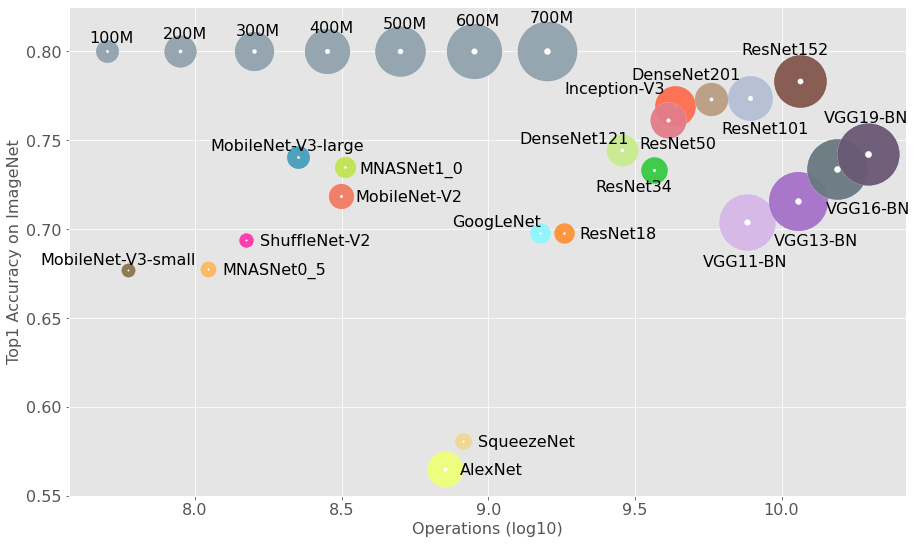

In [203]:
colors=[
    "#eaff56","#bce672","#ff461f","#70f3ff","#a88462",
    "#ffa631","#afdd22","#ed5736","#1685a9","#6e511e",
    "#ff7500","#00bc12","#db5a6b","#a1afc9","#622a1d",
    "#eacd76","#ff0097","#cca4e3","#8d4bbb","#41555d","#412c4f"
]
markers=['o' for _ in range(18)]
plt.figure(figsize=(15,9))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.style.use('ggplot')
base=100000
fs=16
expand=100
names = model_names
x_bias={n:-0.05 for n in model_names}
x_bias["MobileNet-V3-large"]=0.3
x_bias["MobileNet-V3-small"]=0.3
x_bias["Inception-V3"]=0.5
x_bias["DenseNet121"]=0.35
x_bias["DenseNet201"]=0.15
x_bias["ResNet50"]=0.1
x_bias["ResNet101"]=0.1
x_bias["ResNet34"]=0.2
x_bias["ResNet152"]=0.2
x_bias["GoogLeNet"]=0.3
x_bias["VGG11-BN"]=0.15
x_bias["VGG13-BN"]=0.08
x_bias["VGG16-BN"]=0.04
x_bias["VGG19-BN"]=0.15
# x_bias["MNASNet1_0"]=0.0001
y_bias={n:0.0035 for n in model_names}
y_bias["MNASNet1_0"]=-0.003
y_bias["MNASNet0_5"]=-0.003
y_bias["ShuffleNet-V2"]=-0.003
y_bias["AlexNet"]=-0.003
y_bias["ResNet18"]=-0.003
y_bias["ResNet34"]=-0.012
y_bias["ResNet50"]=-0.016
y_bias["ResNet101"]=-0.02
y_bias["ResNet152"]=0.015
y_bias["SqueezeNet"]=-0.003
y_bias["MobileNet-V2"]=-0.003
y_bias["VGG11-BN"]=-0.025
y_bias["VGG13-BN"]=-0.025
y_bias["VGG16-BN"]=-0.025
y_bias["VGG19-BN"]=0.018
y_bias["DenseNet201"]=0.015
log10_ops = [np.log(f)/np.log(10) for f in flops]
M_mem = [(m*4)/10**6 for m in mems]
accs = model_accs
for i in range(len(names)):
    x=log10_ops[i]
    y=accs[i]/100.0
    m=M_mem[i]*5
    s=m
    n=names[i]
    c=colors[i]
    marker=markers[i%13]
#     print(x,y,s,x-x_bias[n],accs[i]+y_bias[n])
    plt.scatter(x,y,s=s+s*0.01,color='w',marker=marker,alpha=0.8)
    plt.scatter(x,y,s=s,color=c,marker=marker,alpha=0.75,label=names[i])
#     plt.scatter(x,y,s=m,color=c,marker=marker,alpha=1)
    plt.scatter(x,y,s=0.01*s,color='w',marker='o',alpha=1)
    plt.text(x-x_bias[n],y+y_bias[n],n,color='k',fontsize=fs)

v_mem=[100,200,300,400,500,600,700]
x_base_index=7.7
inc=.25
for i in range(len(v_mem)):
    x=x_base_index+i*inc
    y=0.80
    s=v_mem[i]*5
    plt.scatter(x,y,s=s+s*0.01,color='w',marker='o',alpha=0.8)
    plt.scatter(x,y,s=s,color="#758a99",marker='o',alpha=0.75)
    plt.scatter(x,y,s=s*0.01,color='w',marker='o',alpha=1)
    plt.text(x-0.06,y+0.0075*i*inc+0.005,"%dM"%v_mem[i],fontsize=fs)
# plt.legend(ncol=2,bbox_to_anchor=(.7,0.35),fontsize=fs)
plt.xlabel("Operations (log10)",fontsize=fs)
plt.ylabel("Top1 Accuracy on ImageNet",fontsize=fs)
# plt.xlabel(u"操作数 (log10)",fontsize=fs)
# plt.ylabel(u"在mageNet上的推理精度(Top1)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.ylim([0.55,0.825])
# plt.xlim([6.75,8.65])
plt.savefig("./figures/mem_ops.pdf",bbox_inches = 'tight',pad_inches = 0)

In [10]:
# ! pip install pandas
import pandas as pd
M_flops = [f/10**9 for f in flops]
M_mem = [(m*4)/10**6 for m in mems]
model_info = {"Model":model_names,
             "Flops (GFLOPs)":M_flops,
             "Memory (MB)":M_mem,
             "Top-1 (\%)":model_accs}
df_model_info= pd.DataFrame(model_info)

In [11]:
df_model_info.sort_values(['Top-1 (\%)'])
df_model_info

,Model,Flops (GFLOPs),Memory (MB),Top-1 (\%)
0,AlexNet,0.714692,248.841088,56.522
1,DenseNet121,2.865672,197.203168,74.434
2,DenseNet201,4.340971,323.091168,76.896
3,GoogLeNet,1.504880,79.461248,69.778
4,Inception-V3,5.731284,215.221248,77.294
5,MNASNet0_5,0.110587,47.024928,67.734
6,MNASNet1_0,0.325329,84.974368,73.456
7,MobileNet-V2,0.314130,121.137280,71.878
8,MobileNet-V3-large,0.225442,99.566112,74.042
9,MobileNet-V3-small,0.059368,35.224672,67.668


# Compute roofline model

In [31]:
gpus={
#      "QS-855+":[1.032*10**12,34.1*2**30,10],
#      "QS-888+":[1.72*10**12,51.2*2**30,10],
    "1080ti":[10.616*10**12,484*2**30,250],
     "2080ti":[11.75*10**12,616*2**30,250],
     "3090":[29.28*10**12,936.2*2**30,350],
#      "A6000":[31.29*10**12,768*2**30,300]
     }
desktopcpus={
    "Xeon E5-2678 v3":[1.9/2*10**12,68*2**30,120]
}
mobilesocs={
     "QS-855+":[1.032*10**12,34.1*2**30,10],
     "QS-888+":[1.72*10**12,51.2*2**30,10],
}

def get_device_roofline(devices,max_I=30):
    devices_Is={k:v[0]/v[1] for k,v in devices.items()}
    devices_lines={}
    for k in devices.keys():
        I = devices_Is[k]
        f = devices[k][0]/10**12
        b = devices[k][1]
        line1=[[0,I],[0,f]]
        line2=[[I,max_I],[f,f]]
        devices_lines[k] = [line1,line2]
    return devices_Is, devices_lines
gpus_Is, gpus_lines = get_device_roofline(gpus)
cpus_Is, cpus_lines = get_device_roofline(desktopcpus)
mcpus_Is, mcpus_lines = get_device_roofline(mobilesocs)
# mcpus_Is, mcpus_lines

In [16]:
Is = []
mem_bytes = [m*4 for m in mems]
for f,m in zip(flops,mem_bytes):
    Is.append(f/m)
# Is

# Compute the attainable performance of models on different platform

In [33]:
def get_attainable_perf(devices,Is):
    '''
    devices: target devices
    Is: the algorithm computing intensive
    '''
    attainable_perf={}
    devices_Is, devices_lines = get_device_roofline(devices)
    for k in devices.keys():
        attainable_perf[k]=[]
        I_max=devices_Is[k]
        f_max=devices[k][0]
        m_max=devices[k][1]
        for I in Is:
            if I >= I_max:
                attainable_perf[k].append(f_max)
            else:
                attainable_perf[k].append(I*m_max)
    # real_f
    attainable_perf_h={}
    for k in attainable_perf.keys():
        attainable_perf_h[k]=[0]*len(attainable_perf[k])
        for i in range(len(attainable_perf[k])):
            attainable_perf_h[k][i]=attainable_perf[k][i]/10**12
    return attainable_perf,attainable_perf_h
real_f, real_f_g = get_attainable_perf(gpus,Is)
# real_f_g
# real_f={}
# for k in gpus.keys():
#     real_f[k]=[]
#     I_max=gpus_Is[k]
#     f_max=gpus[k][0]
#     m_max=gpus[k][1]
#     for I in Is:
#         if I >= I_max:
#             real_f[k].append(f_max)
#         else:
#             real_f[k].append(I*m_max)
# # real_f
# real_f_g={}
# for k in real_f.keys():
#     real_f_g[k]=[0]*len(real_f[k])
#     for i in range(len(real_f[k])):
#         real_f_g[k][i]=real_f[k][i]/10**12
# # real_f_g

# Draw the roofline---on GPUs

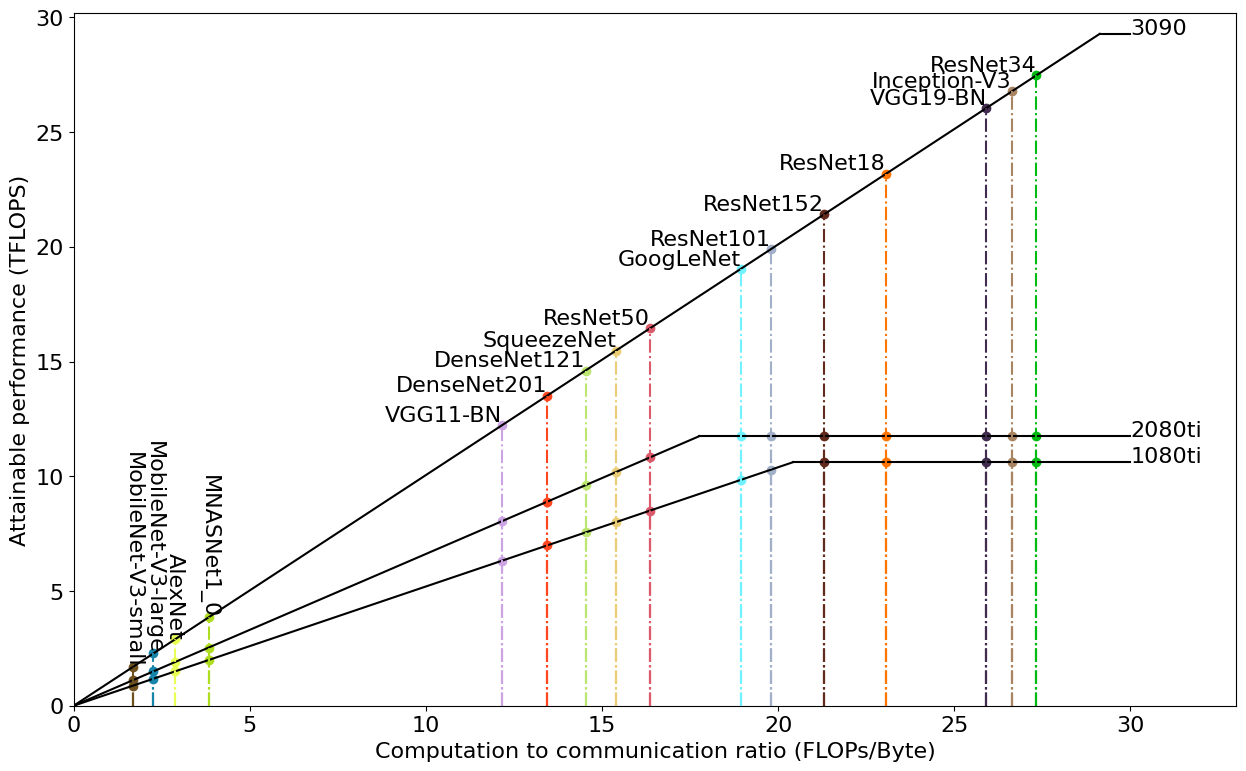

In [34]:
colors=[
    "#eaff56","#bce672","#ff461f","#70f3ff","#a88462",
    "#ffa631","#afdd22","#ed5736","#1685a9","#6e511e",
    "#ff7500","#00bc12","#db5a6b","#a1afc9","#622a1d",
    "#eacd76","#ff0097","#cca4e3","#8d4bbb","#41555d","#412c4f"
]
markers=['o' for _ in range(18)]
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.style.use('default')
plt.figure(figsize=(15,9))
fs=16
# Draw roofline
for k in gpus.keys():
    plt.plot(*gpus_lines[k][0],'k')
    plt.plot(*gpus_lines[k][1],'k')
    plt.text(gpus_lines[k][1][0][1],gpus_lines[k][1][1][1],k,fontsize=fs)
plt.xlim([0,33])
plt.ylim([0,30.2])

# Draw model computing performance
width = 0.5
order_ids = [(i,I) for i,I in zip(range(len(Is)),Is)]
order_ids.sort(key=lambda x:x[1])
for j,k in enumerate(gpus.keys()):
    pre_x = 0
    for ordere_i in range(len(Is)):
        i = order_ids[ordere_i][0]
        x = Is[i]
        y = real_f_g[k][i]
        if ordere_i == 0 or abs(x-pre_x)>=width:
            pre_x = x
        else:
            continue
        plt.plot([x,x],[0,y],color=colors[i],linestyle="-.")
#         label = model_names[i] if j==0 else None
        label=None
        plt.scatter([x],[y],color=colors[i],marker="o",label=label)
        if j == len(gpus.keys())-1:
            if x<5:
                plt.text(x,y,model_names[i],rotation=-90,verticalalignment="bottom",horizontalalignment="center",fontsize=fs)
            else:
                plt.text(x,y,model_names[i],verticalalignment="bottom",horizontalalignment="right",fontsize=fs)
# plt.legend()
plt.xlabel("Computation to communication ratio (FLOPs/Byte)",fontsize=fs)
plt.ylabel("Attainable performance (TFLOPS)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.savefig("./figures/roofline-on-GPUs.pdf",bbox_inches = 'tight',pad_inches = 0)

# Draw the roofline---on mobile GPUs

In [25]:
devices_lines

{'QS-888+': [[[0, 31.28661774098873], [0, 1.72]],
  [[31.28661774098873, 30], [1.72, 1.72]]],
 'Apple A14 Bionic': [[[0, 41.95048312637463], [0, 1.536]],
  [[41.95048312637463, 30], [1.536, 1.536]]],
 'Hisilicon Kirin 9000': [[[0, 49.36009645462036], [0, 2.332]],
  [[49.36009645462036, 30], [2.332, 2.332]]]}

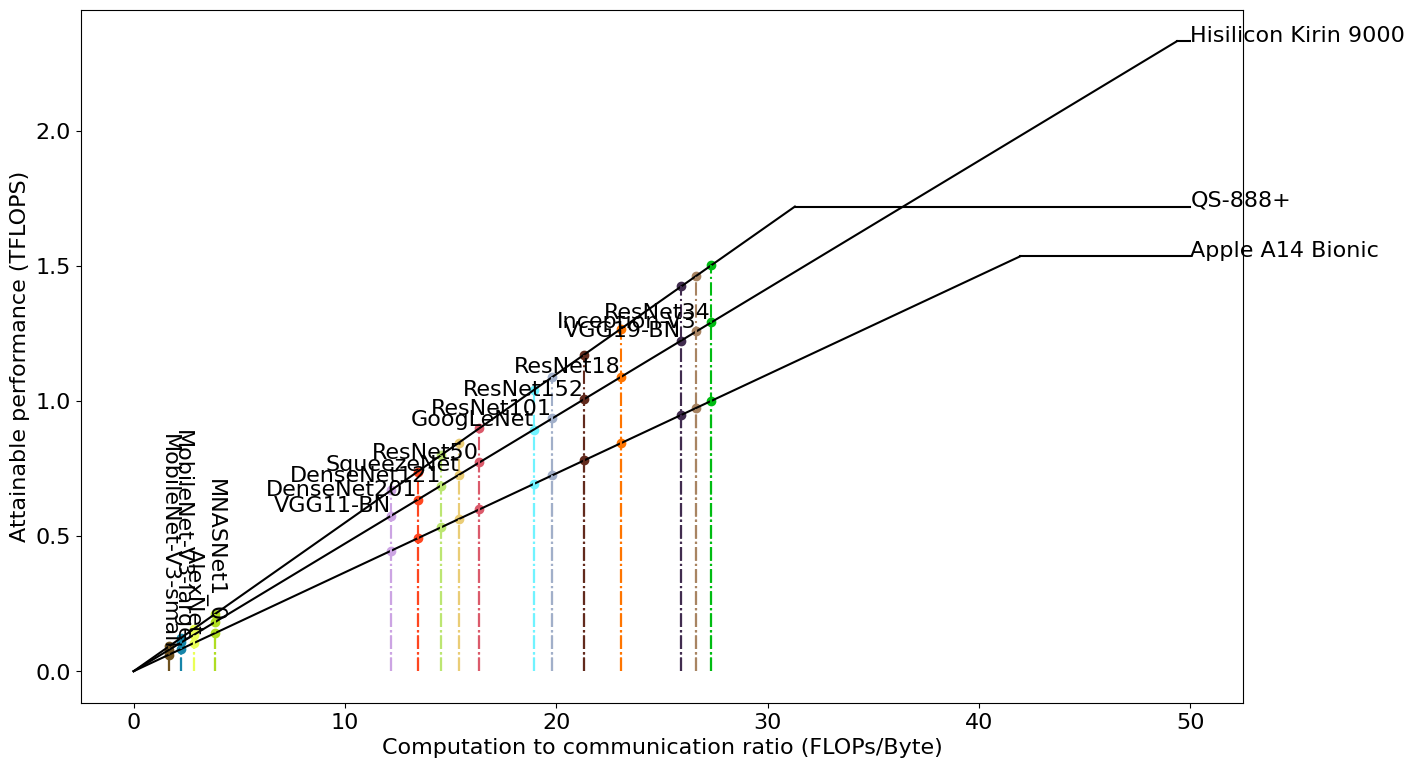

In [27]:
mobilegpus={
     "QS-888+":[1.72*10**12,51.2*2**30,10],
     "Apple A14 Bionic":[1.536*10**12,34.1*2**30,10],
     "Hisilicon Kirin 9000":[2.332*10**12,44*2**30,10],
}
colors=[
    "#eaff56","#bce672","#ff461f","#70f3ff","#a88462",
    "#ffa631","#afdd22","#ed5736","#1685a9","#6e511e",
    "#ff7500","#00bc12","#db5a6b","#a1afc9","#622a1d",
    "#eacd76","#ff0097","#cca4e3","#8d4bbb","#41555d","#412c4f"
]
devices = mobilegpus
devices_Is, devices_lines = get_device_roofline(devices,max_I=50)
real_f, real_f_g = get_attainable_perf(devices,Is)
markers=['o' for _ in range(18)]
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.style.use('default')
plt.figure(figsize=(15,9))
fs=16
# Draw roofline
for k in devices.keys():
    plt.plot(*devices_lines[k][0],'k')
    plt.plot(*devices_lines[k][1],'k')
    plt.text(devices_lines[k][1][0][1],devices_lines[k][1][1][1],k,fontsize=fs)
# plt.xlim([0,33])
# plt.ylim([0,30.2])

# Draw model computing performance
width = 0.5
order_ids = [(i,I) for i,I in zip(range(len(Is)),Is)]
order_ids.sort(key=lambda x:x[1])
for j,k in enumerate(devices.keys()):
    pre_x = 0
    for ordere_i in range(len(Is)):
        i = order_ids[ordere_i][0]
        x = Is[i]
        y = real_f_g[k][i]
        if ordere_i == 0 or abs(x-pre_x)>=width:
            pre_x = x
        else:
            continue
        plt.plot([x,x],[0,y],color=colors[i],linestyle="-.")
#         label = model_names[i] if j==0 else None
        label=None
        plt.scatter([x],[y],color=colors[i],marker="o",label=label)
        if j == len(gpus.keys())-1:
            if x<5:
                plt.text(x,y,model_names[i],rotation=-90,verticalalignment="bottom",horizontalalignment="center",fontsize=fs)
            else:
                plt.text(x,y,model_names[i],verticalalignment="bottom",horizontalalignment="right",fontsize=fs)
# plt.legend()
plt.xlabel("Computation to communication ratio (FLOPs/Byte)",fontsize=fs)
plt.ylabel("Attainable performance (TFLOPS)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.savefig("./figures/roofline-on-mobileGPUs.pdf",bbox_inches = 'tight',pad_inches = 0)

# Draw the attainable performance under different devices

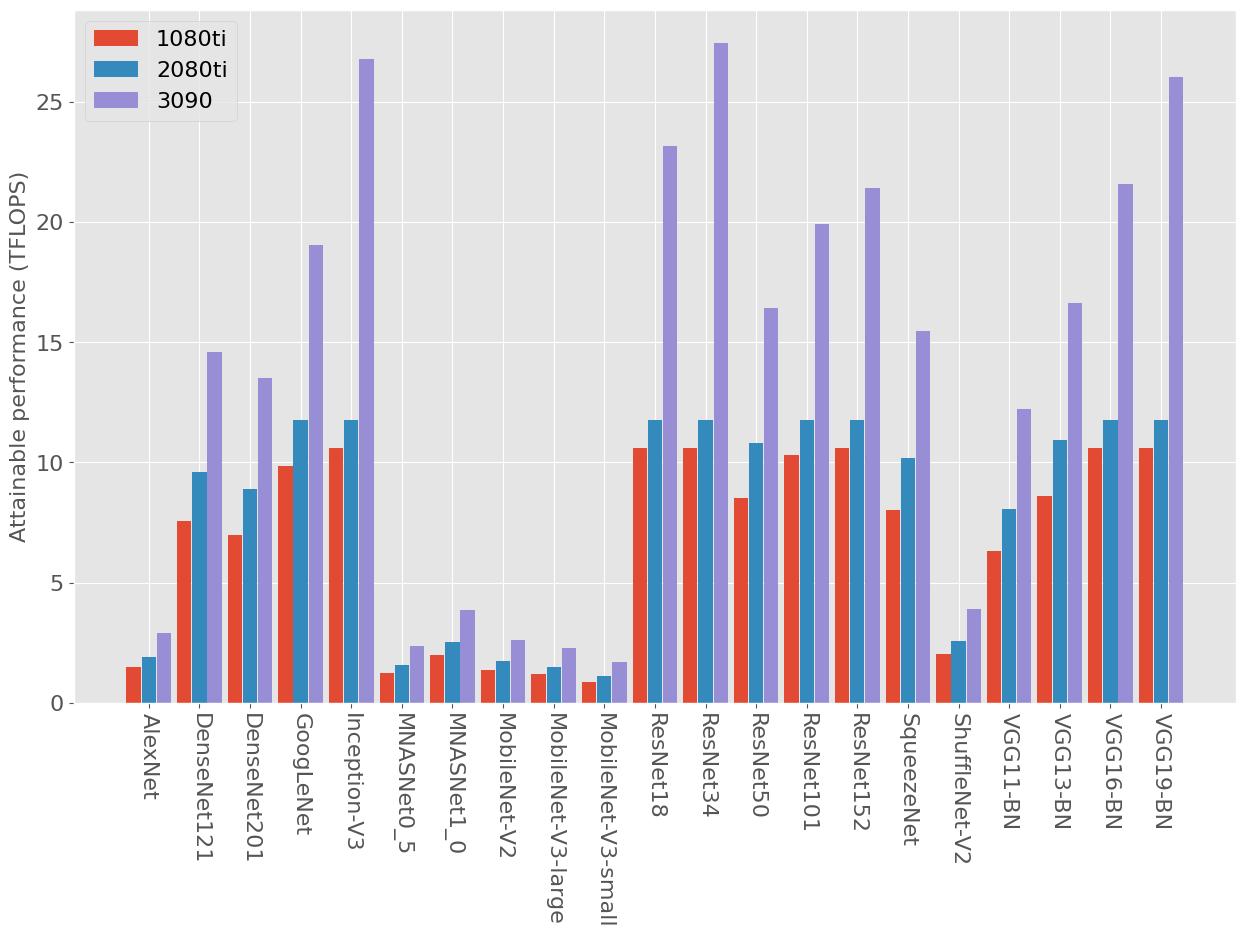

In [35]:
plt.style.use("ggplot")
plt.figure(figsize=(15,9))
fs=16
width=(1-0.15)/len(gpus.keys())
bias=(1-0.1)/len(gpus.keys())
xaxis = range(len(model_keys))
for i,k in enumerate(gpus.keys()):
    x = [v+bias*i for v in xaxis]
    plt.bar(x,real_f_g[k],width=width,label=k)
plt.xticks([v+bias*(len(gpus.keys())/2.-.5) for v in xaxis],model_names,rotation=-90)
plt.legend(fontsize=fs)
plt.ylabel("Attainable performance (TFLOPS)",fontsize=fs)
plt.tick_params(labelsize=fs)
# plt.savefig("./figures/attainable-performance-on-devices.pdf",bbox_inches = 'tight',pad_inches = 0)

# Stat the computing efficiency on devices

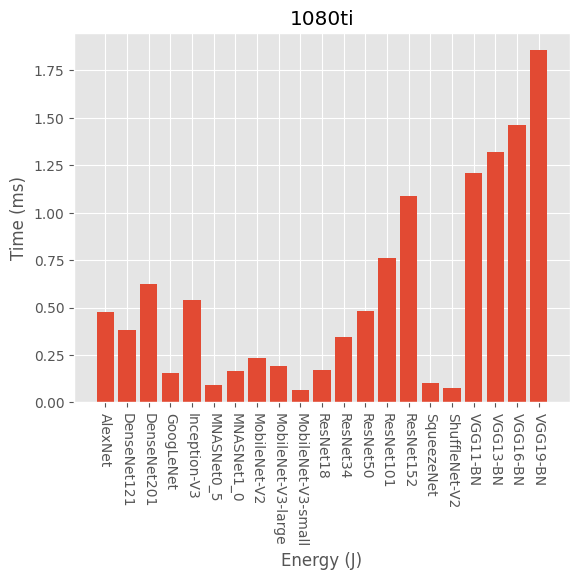

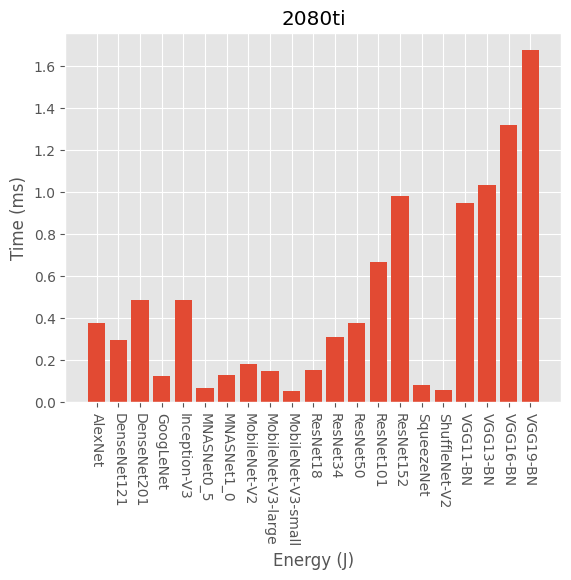

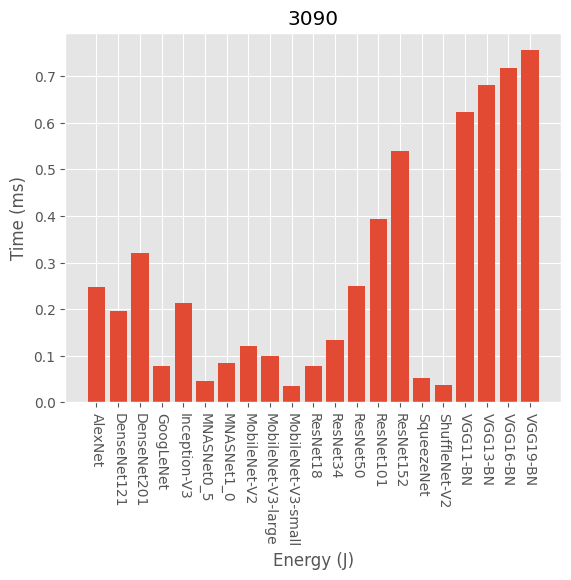

In [36]:
inf_time={}
inf_energy={}
for i,k in enumerate(gpus.keys()):
    inf_time[k]=[0]*len(model_keys)
    inf_energy[k]=[0]*len(model_keys)
    for j in range(len(model_keys)):
        inf_time[k][j] = flops[j]/real_f[k][j]*1000 
        inf_energy[k][j] = inf_time[k][j]*gpus[k][2]/1000
# inf_time,inf_energy
# Draw the inference time vs inference enery
for i,k in enumerate(gpus.keys()):
    x = inf_energy[k]
    y = inf_time[k]
    plt.bar(range(len(model_keys)),y)
    plt.xticks(range(len(model_keys)),model_names,rotation=-90)
#     for j in range(len(model_keys)):
#         x = inf_energy[k][j]
#         y = inf_time[k][j]
    plt.title(k)
    plt.xlabel("Energy (J)")
    plt.ylabel("Time (ms)")
    plt.show()

In [340]:
len(gpus.keys())

5

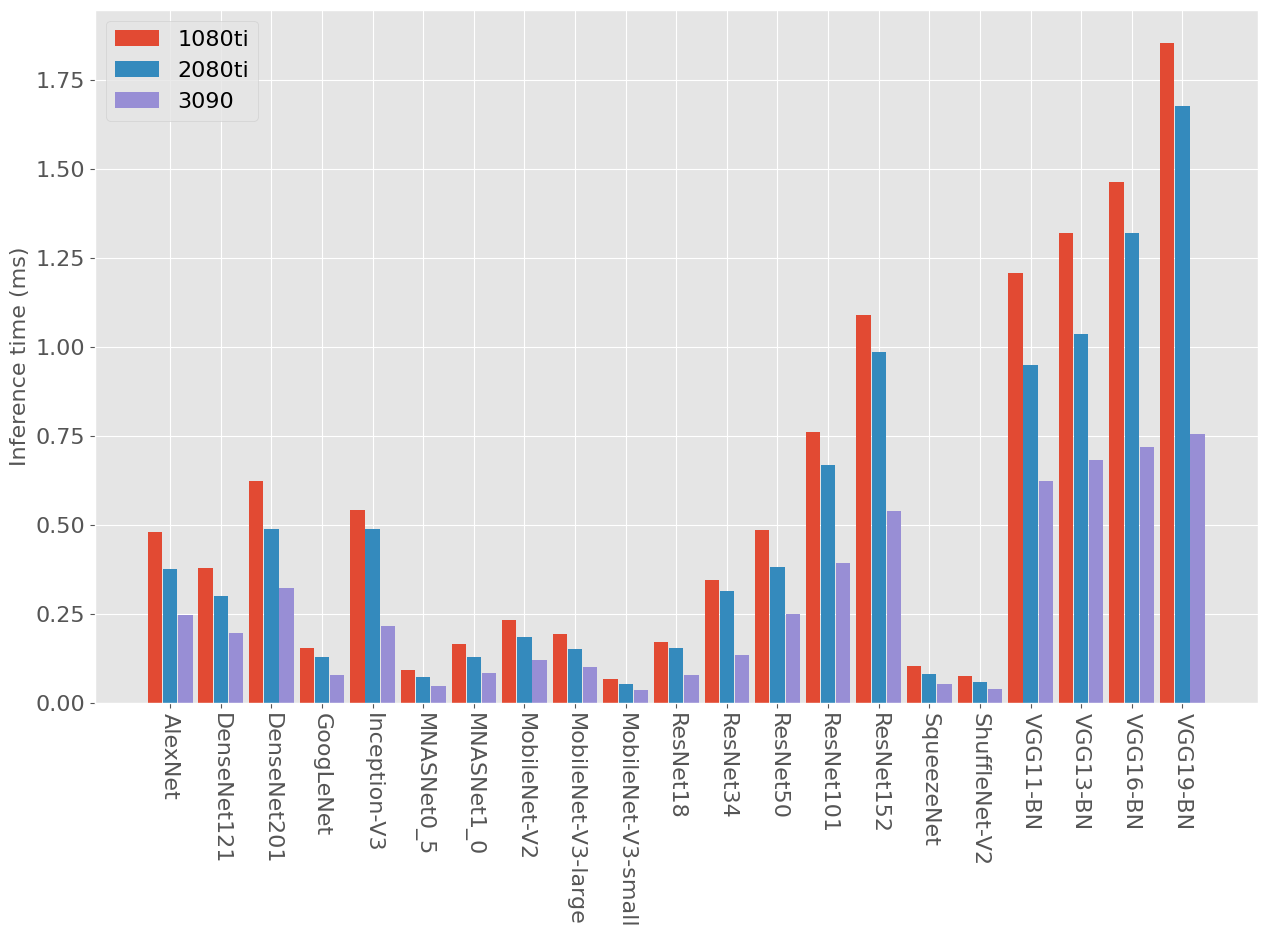

In [37]:
plt.style.use("ggplot")
plt.figure(figsize=(15,9))
fs=16
width=(1-0.15)/len(gpus.keys())
bias=(1-0.1)/len(gpus.keys())
xaxis = range(len(model_keys))
for i,k in enumerate(gpus.keys()):
    x = [v+bias*i for v in xaxis]
    y = inf_time[k]
    plt.bar(x,y,width=width,label=k)
plt.xticks([v+bias*(len(gpus.keys())/2.-.5) for v in xaxis],model_names,rotation=-90)
plt.legend(fontsize=fs)
plt.ylabel("Inference time (ms)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.savefig("./figures/Inference-time(ms)-on-devices.pdf",bbox_inches = 'tight',pad_inches = 0)

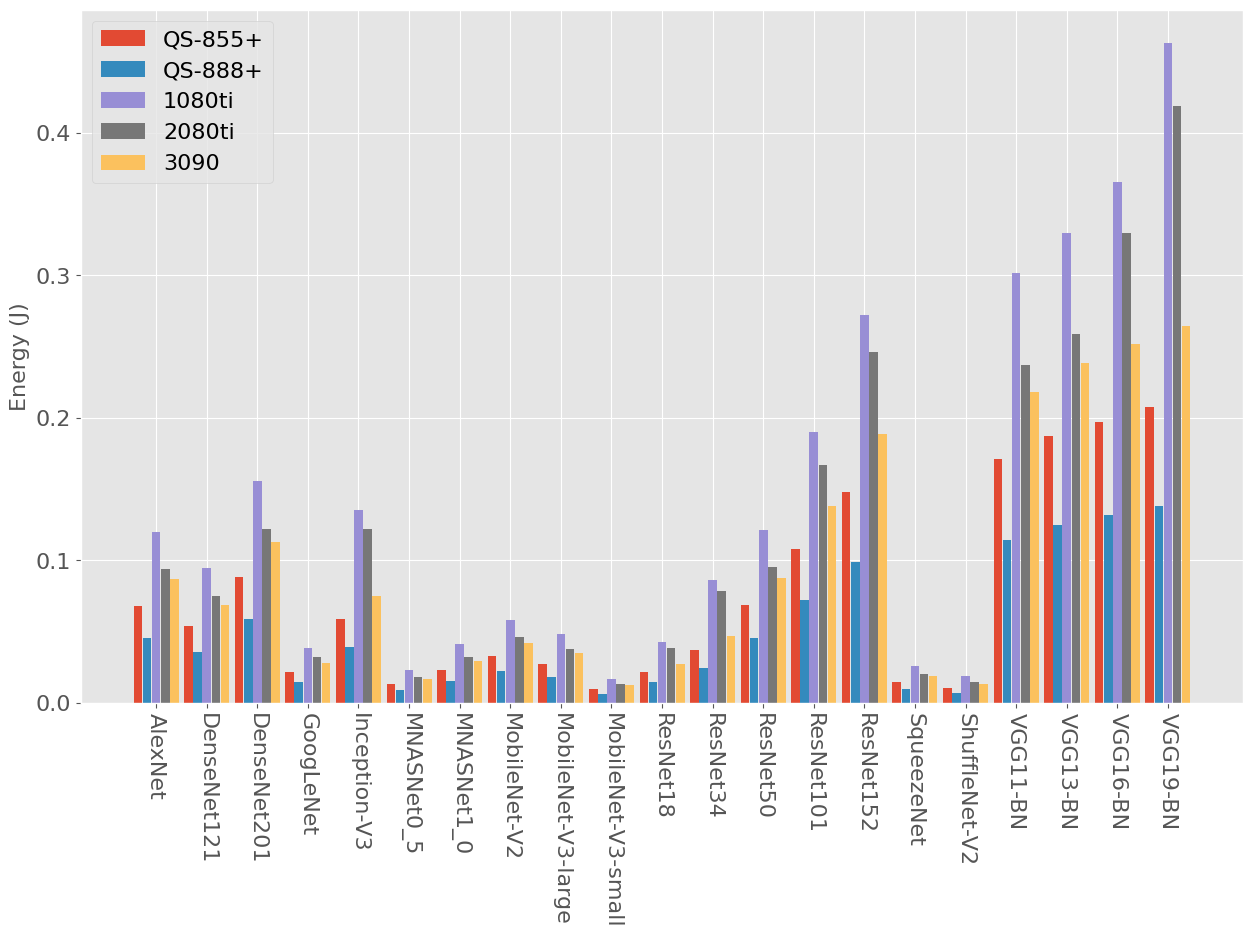

In [345]:
plt.style.use("ggplot")
plt.figure(figsize=(15,9))
fs=16
width=(1-0.15)/len(gpus.keys())
bias=(1-0.1)/len(gpus.keys())
xaxis = range(len(model_keys))
for i,k in enumerate(gpus.keys()):
    x = [v+bias*i for v in xaxis]
    y = inf_energy[k]
    plt.bar(x,y,width=width,label=k)
plt.xticks([v+bias*(len(gpus.keys())/2.-.5) for v in xaxis],model_names,rotation=-90)
plt.legend(fontsize=fs)
plt.ylabel("Energy (J)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.savefig("./figures/Inference-energy(J)-on-devices.pdf",bbox_inches = 'tight',pad_inches = 0)

In [348]:
def MAH2J(mah):
    v = 3.7
    e = 3.7*mah/1000*3600
    return e
MAH2J(4000)/10/3600

1.48

# Speedup bu Quantization of ALexNet FP32->FP16


In [65]:
alexnet = models_objs[0]
# input_shape=model_inputshape[0]
input_shape = (3,224,224)
def get_flops_params_mems(model,input_shape,batch_size=2,name="model"):
    inputs=torch.randn(batch_size,*input_shape)
    flops,params,mems = [], [], []
    _flops, _params = profile(model, inputs=(inputs, ),verbose=False)
    _flops = _flops/batch_size
    try:
        _mems=_params+get_feature_size(model,inputs)/batch_size
        print("Stat flops, params and mems of %s is [%.2fGFLOPs,%.2fM, %.2fM]"%(name,_flops/10**9,_params*4/2**20,_mems*4/2**20))
        mems.append(_mems)
    except:
        print(name)
    flops.append(_flops)
    params.append(_params)
    return flops,params,mems
def get_Is(flops,mems,bitwidth=32):
    Is = []
    mem_bytes = [m*bitwidth/8 for m in mems]
    for f,m in zip(flops,mem_bytes):
        Is.append(f/m)
    return Is
flops,params,mems = get_flops_params_mems(models_objs[0],input_shape,batch_size=2)
# flops,params,mems
Is

Stat flops, params and mems of model is [0.71GFLOPs,233.08M, 237.31M]


[5.848462181534656]

In [109]:
gpus32={
     "RTX 2080ti":[11.75*10**12,616*2**30,250]
}
gpus16={
     "RTX 2080ti":[2*11.75*10**12,2*616*2**30,250]
}
Is16 = get_Is(flops,params,bitwidth=16)
Is32 = get_Is(flops,params,bitwidth=32)
real_f32,real_fh32 = get_attainable_perf(gpus32,Is32)
real_f16,real_fh16 = get_attainable_perf(gpus16,Is16)
gpus32_Is, gpus32_lines = get_device_roofline(gpus32)
gpus16_Is, gpus16_lines = get_device_roofline(gpus16)

In [110]:
Is32,Is16,real_fh32, real_fh16

([2.924231090767328],
 [5.848462181534656],
 {'RTX 2080ti': [1.9341594427219808]},
 {'RTX 2080ti': [7.736637770887923]})

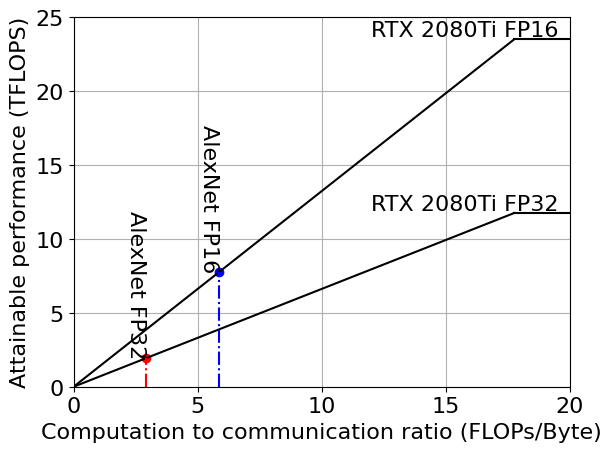

In [139]:
# Draw roofline
plt.style.use("default")
k = "RTX 2080ti"
plt.plot(*gpus32_lines[k][0],'k')
plt.plot(*gpus32_lines[k][1],'k')
plt.text(gpus32_lines[k][1][0][1]-18,gpus32_lines[k][1][1][1]+0.2,"RTX 2080Ti FP32",fontsize=fs)
plt.plot(*gpus16_lines[k][0],'k')
plt.plot(*gpus16_lines[k][1],'k')
plt.text(gpus16_lines[k][1][0][1]-18,gpus16_lines[k][1][1][1]+0.2,"RTX 2080Ti FP16",fontsize=fs)
x32 = Is32[0]
y32 = real_fh32["RTX 2080ti"][0]
plt.plot([x32,x32],[0,y32],color='r',linestyle="-.")
label="AlexNet FP32"
plt.scatter([x32],[y32],color='r',marker="o",label=label)
x16 = Is16[0]
y16 = real_fh16["RTX 2080ti"][0]
plt.plot([x16,x16],[0,y16],color='b',linestyle="-.")
label="AlexNet FP16"
plt.scatter([x16],[y16],color='b',marker="o",label=label)
plt.text(x16,y16,"AlexNet FP16",rotation=-90,verticalalignment="bottom",horizontalalignment="right",fontsize=fs)
plt.text(x32,y32,"AlexNet FP32",rotation=-90,verticalalignment="bottom",horizontalalignment="right",fontsize=fs)
plt.xlim([0,20])
plt.ylim([0,25])
plt.grid()
plt.xlabel("Computation to communication ratio (FLOPs/Byte)",fontsize=fs)
plt.ylabel("Attainable performance (TFLOPS)",fontsize=fs)
plt.tick_params(labelsize=fs)
plt.savefig("./figures/roofline-Multi-AlexNet-on-RTX2080ti.pdf",bbox_inches = 'tight',pad_inches = 0)

In [1]:
import torch
print("Pytorch version：")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is :")
print(torch.backends.cudnn.version())

Pytorch version：
1.9.0+cu111
CUDA Version: 
11.1
cuDNN version is :
8005
